In [137]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/imdb_2.csv')
# train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
# test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [168]:
# Create binning for stratification
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 3
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
df['ratingBin'] = binner.fit_transform(df[['averageRating']])

In [169]:
from sklearn.model_selection import train_test_split
import numpy as np

# Partial oversize of minority classes to reduce imbalance
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['ratingBin'])  # 80% train, 20% test
test, val = train_test_split(test, test_size=0.5, random_state=42, stratify=test['ratingBin'])  # 15% val, 15% test

max_size = train['ratingBin'].value_counts().max()

train_resampled = train.copy()

# Oversample minority classes
for row in train.groupby(['ratingBin']).size().items():
    if row[1] < max_size * 0.6:
        n_add = (max_size - row[1]) * 0.02
        to_add = train[train['ratingBin'] == row[0]].sample(n=int(n_add), replace=True, random_state=42)
        train_resampled = pd.concat([train_resampled, to_add], ignore_index=True)
        
# Undersample majority classes
# max_size = int(max_size * 0.6)
# for row in train_resampled.groupby(['ratingBin']).size().items():
#     if row[1] > max_size:
#         n_remove = int((row[1] - max_size) * 0.2)
#         to_remove = train_resampled[train_resampled['ratingBin'] == row[0]].sample(n=n_remove, random_state=42)
#         train_resampled = train_resampled.drop(to_remove.index)

X_train = train_resampled.drop(columns=['averageRating', 'ratingBin'])
y_train = train_resampled['averageRating']

X_val = val.drop(columns=['averageRating', 'ratingBin'])
y_val = val['averageRating']

X_test = test.drop(columns=['averageRating', 'ratingBin'])
y_test = test['averageRating']

In [170]:
train.shape, train_resampled.shape

((104671, 35), (105727, 35))

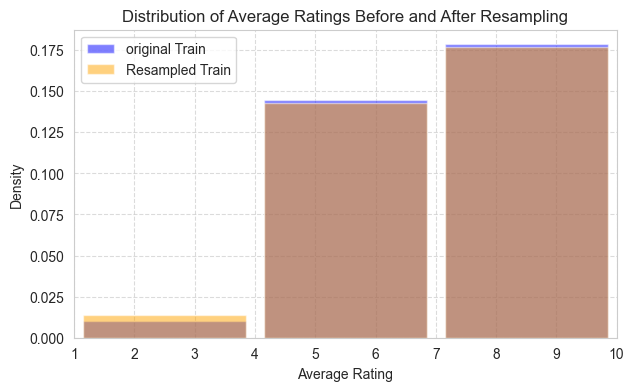

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.hist(train['averageRating'], bins=n_bins, alpha=0.5, label='original Train', density=True, color='blue', rwidth=0.9)
plt.hist(train_resampled['averageRating'], bins=n_bins, alpha=0.5, label='Resampled Train', density=True, color='orange', rwidth=0.9)
plt.grid(alpha=0.7, linestyle='--')
plt.legend()
plt.title('Distribution of Average Ratings Before and After Resampling')
plt.ylabel('Density')
plt.xlabel('Average Rating')
plt.xlim(1, 10)
plt.show()

In [172]:
# Feature selection
selected_features = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
    
    'genre1', 'genre2', 'genre3',
    
    'short', 'tvEpisode', 'tvMiniSeries',
    'tvMovie', 'tvSeries', 'tvShort',
    'tvSpecial', 'video', 'videoGame',
    
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Australia',
    'Continent Unknown'
]

numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
]

titletype_cols = [
    'short', 'tvEpisode', 'tvMiniSeries',
    'tvMovie', 'tvSeries', 'tvShort',
    'tvSpecial', 'video', 'videoGame'
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Australia',
    'Continent Unknown'
]

# selected_features / titletype_cols
to_scale = [feat for feat in selected_features if feat not in titletype_cols]

genre_cols = ['genre1', 'genre2', 'genre3']

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

In [173]:
# Preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np


to_log = [
    'totalCredits', 'numRegions', 'ratingCount',
    'castNumber', 'companiesNumber', 'writerCredits',
    'directorsCredits', 'totalNominations', 'totalMedia',
    'totalReviews',
]

# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

# Sort columns following selected_features order
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Scale all features but titletype feats (numerical_cols / titletype_cols)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[to_scale])
X_val_scaled = scaler.transform(X_val[to_scale])
X_test_scaled = scaler.transform(X_test[to_scale])

# Replace scaled columns back into DataFrames
X_train[to_scale] = X_train_scaled
X_val[to_scale] = X_val_scaled
X_test[to_scale] = X_test_scaled

In [174]:
# Split the input data for the three branches
X_train_split = {
    'numerical_input': X_train[numerical_cols].values,
    'titleType_input': X_train[titletype_cols].values,
    'region_input': X_train[region_cols].values,
    'genre_input': X_train[genre_cols].values
}

X_val_split = {
    'numerical_input': X_val[numerical_cols].values,
    'titleType_input': X_val[titletype_cols].values,
    'region_input': X_val[region_cols].values,
    'genre_input': X_val[genre_cols].values
}

X_test_split = {
    'numerical_input': X_test[numerical_cols].values,
    'titleType_input': X_test[titletype_cols].values,
    'region_input': X_test[region_cols].values,
    'genre_input': X_test[genre_cols].values
}

In [175]:
train[region_cols]

,Asia,Africa,Europe,North America,South America,Australia,Continent Unknown
56059,0,0,0,0,0,0,0
10110,0,0,1,1,1,0,0
133716,0,0,1,0,0,0,0
68796,0,0,0,0,0,0,0
137748,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...
147579,0,0,1,0,0,0,0
61767,0,0,0,0,0,0,0
121911,0,0,0,0,0,0,0
141793,0,0,1,0,0,0,0


In [176]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


# Numerical branch
numerical_input = layers.Input(shape=(numerical_cols.__len__(),), name='numerical_input')

# numerical_branch = layers.Dense(104, use_bias=False)(numerical_input)
# numerical_branch = layers.BatchNormalization()(numerical_branch)
# numerical_branch = layers.Activation('swish')(numerical_branch)


# TitleType branch
titletype_input = layers.Input(shape=(titletype_cols.__len__(),), name='titleType_input')

titletype_branch = layers.Embedding(
    input_dim=titletype_cols.__len__(),
    output_dim=8,
    input_length=1
)(titletype_input)
titletype_branch = layers.Flatten()(titletype_branch)


# Region branch
region_input = layers.Input(shape=(region_cols.__len__(),), name='region_input')

region_branch = layers.Dense(16, use_bias=False)(region_input)
region_branch = layers.BatchNormalization()(region_branch)
region_branch = layers.Activation('relu')(region_branch)


# Genre branch
genre_input = layers.Input(shape=(3,), name='genre_input')

genre_branch = layers.Dense(8, use_bias=False)(genre_input)
genre_branch = layers.BatchNormalization()(genre_branch)
genre_branch = layers.Activation('relu')(genre_branch)


# Concatenate branches
concatenated = layers.concatenate([numerical_input, titletype_branch, region_branch, genre_branch])

# 1st layer
x = layers.Dense(128, use_bias=False)(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
# x = layers.PReLU()(x)
x = layers.Dropout(0.4)(x)

# 2nd layer
x = layers.Dense(128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
# x = layers.PReLU()(x)
x = layers.Dropout(0.4)(x)

# Tested:
# PReLU, swish(Best; same R-squared while having some lower ratings)
# LeakyReLU
# ReLU



output = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=[numerical_input, titletype_input, region_input, genre_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae', 'r2_score'],
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [177]:
y_train = np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)
y_test = np.array(y_test).reshape(-1)

history = model.fit(
    X_train_split, y_train, epochs=200,
    batch_size=64,
    validation_data=(X_val_split, y_val),
    # Early stopping
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20,
            restore_best_weights=True
        )],
    verbose=1
)

"--------------------DONE--------------------"

Epoch 1/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 13.7521 - mae: 2.9642 - r2_score: -6.1808 - val_loss: 3.1358 - val_mae: 1.5000 - val_r2_score: -0.7299
Epoch 2/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.9448 - mae: 1.3500 - r2_score: -0.5034 - val_loss: 2.3349 - val_mae: 1.2549 - val_r2_score: -0.2880
Epoch 3/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.4129 - mae: 1.2134 - r2_score: -0.2417 - val_loss: 1.9783 - val_mae: 1.1296 - val_r2_score: -0.0914
Epoch 4/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.1764 - mae: 1.1434 - r2_score: -0.1193 - val_loss: 1.6702 - val_mae: 1.0246 - val_r2_score: 0.0787
Epoch 5/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.9868 - mae: 1.0844 - r2_score: -0.0115 - val_loss: 1.5817 - val_mae: 0.9845 - val_r2_score: 0.1275
Epoch 6/200
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.8527 - mae: 1.0462 - r2_score: 0.0497 - val_loss: 1.4579 - val_mae: 0.9257 - val_r2_score: 0.1957
Epoch 7/200


'--------------------DONE--------------------'

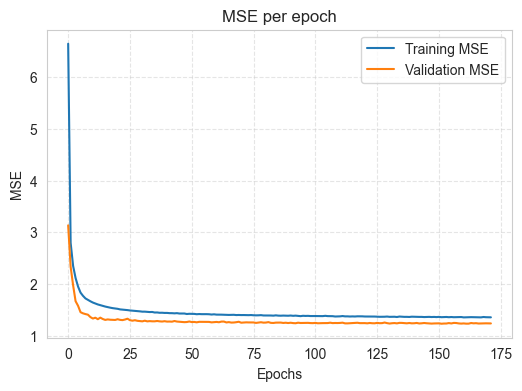

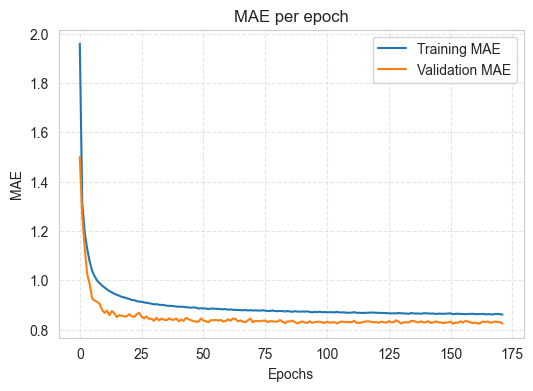

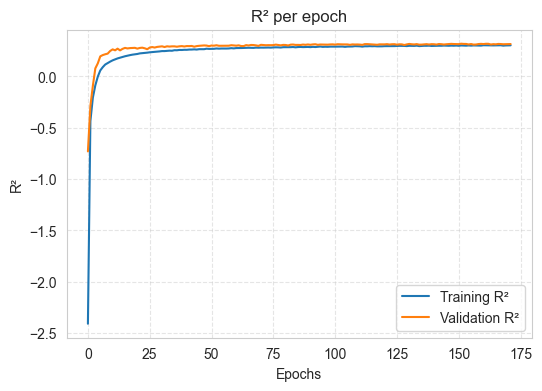

In [178]:
# Plot history
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE per epoch')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(6, 4))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE per epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

# Plot R²
plt.figure(figsize=(6, 4))
plt.plot(history.history['r2_score'], label='Training R²')
plt.plot(history.history['val_r2_score'], label='Validation R²')
plt.title('R² per epoch')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

In [179]:
# R-squared, MSE and MAE computation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test_split).ravel()

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

701/701 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MSE: 1.2233333829677258
MAE: 0.8177645800425121
R-squared: 0.32513275306724254


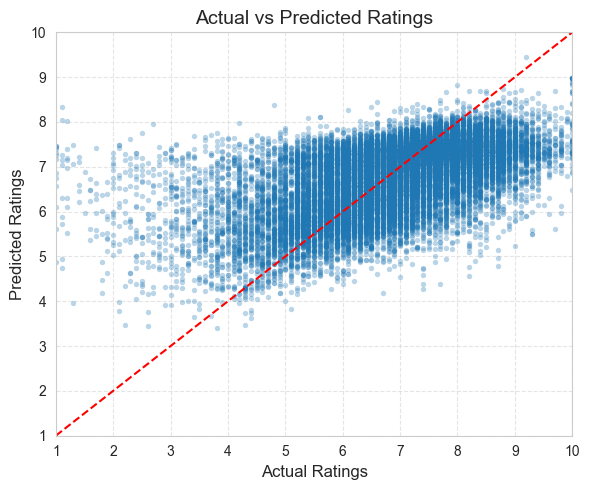

In [180]:
from pyparsing import line
import seaborn as sns

plt.figure(figsize=(6,5))  # larghezza 8, altezza 6
sns.set_style("whitegrid")

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.3, s=15, linewidth=0)

# Diagonal line
lims = [1, 10]
plt.plot(lims, lims, 'r--', linewidth=1.5)

plt.xlabel("Actual Ratings", fontsize=12)
plt.ylabel("Predicted Ratings", fontsize=12)
plt.title(f"Actual vs Predicted Ratings", fontsize=14)
plt.xlim(lims)
plt.ylim(lims)

# Grid 
plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

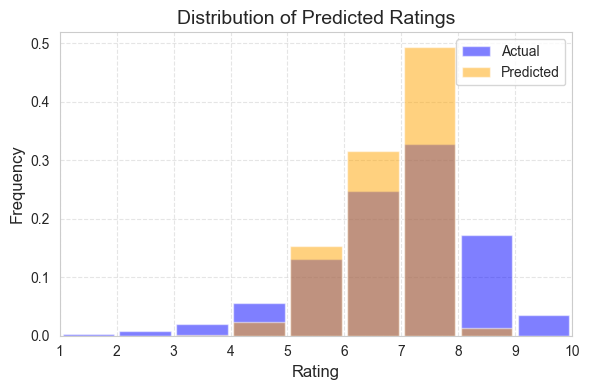

In [187]:
# Plot distribution of precitions
binning = np.linspace(1, 10, 10)

plt.figure(figsize=(6,4))
plt.hist(y_test, bins=binning, alpha=0.5, color='blue', rwidth=0.9, label='Actual', density=True)
plt.hist(y_pred, bins=binning, alpha=0.5, color='orange', rwidth=0.9, label='Predicted', density=True)
plt.title('Distribution of Predicted Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.xlim(1, 10)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

In [182]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam


# model = keras.Sequential([
#     # Input layer
#     layers.Input(shape=(X_train.shape[1],)),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(64, 'relu'),
#     layers.Dropout(0.4),
#     layers.Dense(32, 'relu'),
#     layers.Dropout(0.4),
#     layers.Dense(1, activation='linear') 
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='mse',
#     metrics=['mae', 'r2_score'],
# )

In [183]:
# import numpy as np

# # Ensure correct shapes
# X_train = np.array(X_train)
# y_train = np.array(y_train).reshape(-1)

# X_test = np.array(X_test)
# y_test = np.array(y_test).reshape(-1)

# history = model.fit(
#     X_train, y_train, epochs=100,
#     batch_size=64, validation_split=0.2,
#     # Early stopping
#     callbacks=[
#         keras.callbacks.EarlyStopping(
#             monitor='val_loss', patience=10,
#             restore_best_weights=True
#         )],
#     verbose=1
# )
# model.evaluate(X_test, y_test)
# y_pred = model.predict(X_test)

In [184]:
# # Plot history
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 4))
# plt.plot(history.history['loss'], label='Training MSE')
# plt.plot(history.history['val_loss'], label='Validation MSE')
# plt.title('MSE per epoch')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.grid(alpha=0.5, linestyle='--')
# plt.legend()
# plt.show()

# # Plot MAE
# plt.figure(figsize=(6, 4))
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('MAE per epoch')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.grid(alpha=0.5, linestyle='--')
# plt.legend()
# plt.show()

# # Plot R²
# plt.figure(figsize=(6, 4))
# plt.plot(history.history['r2_score'], label='Training R²')
# plt.plot(history.history['val_r2_score'], label='Validation R²')
# plt.title('R² per epoch')
# plt.xlabel('Epochs')
# plt.ylabel('R²')
# plt.grid(alpha=0.5, linestyle='--')
# plt.legend()
# plt.show()

In [185]:
# # R-squared, MSE and MAE computation
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# y_pred = model.predict(X_test).ravel()

# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'MAE: {mae}')
# print(f'R-squared: {r2}')

In [186]:
# import seaborn as sns

# plt.figure(figsize=(6,5))  # larghezza 8, altezza 6
# sns.set_style("whitegrid")

# # Scatter plot
# plt.scatter(y_test, y_pred, alpha=0.3, s=10, edgecolor='k', linewidth=0.5)

# # Diagonal line
# lims = [1, 10]
# plt.plot(lims, lims, 'r--', linewidth=1.5)

# plt.xlabel("Actual Ratings", fontsize=12)
# plt.ylabel("Predicted Ratings", fontsize=12)
# plt.title(f"Actual vs Predicted Ratings", fontsize=14)
# plt.xlim(lims)
# plt.ylim(lims)

# # Grid 
# plt.grid(alpha=0.5, linestyle='--')

# plt.tight_layout()
# plt.show()